# Example: NXWriter callback

**NOTE**: work-in-progress

**Objective**

Demonstrate use of `apstools.callbacks.NXWriter` and
`apstools.callbacks.NXWriterAPS` as callbacks and then use either (or both) to
export data from databroker.

**Contents**

- [Use as callback](#Callback)
- [Export data to HDF5 file](#Export)

## Use as callback

To demonstrate how the `NXWriter` is used as a callback, it is necessary to have a data acquisition setup.

This example uses a prebuilt [synApps xxx IOC](https://github.com/epics-modules/xxx) driver, packaged in a [docker](https://www.docker.com/) image
([prjemian/custom-synapps-6.2](https://hub.docker.com/r/prjemian/custom-synapps-6.2/tags)).  The [EPICS IOC](https://docs.epics-controls.org/projects/how-tos/en/latest/getting-started/creating-ioc.html) is configured with prefix `gp:` using the [bash shell script](https://github.com/prjemian/epics-docker/blob/main/v1.1/n5_custom_synApps/start_xxx.sh):

```bash
start_xxx.sh gp
```

This example uses a random number generator (new values at 10 Hz) as a `sensor` and a software simulator of a stepping motor as a positioner, `motor`.  The random number generator is provided by a [userCalc](https://htmlpreview.github.io/?https://raw.githubusercontent.com/epics-modules/calc/R3-6-1/documentation/swaitRecord.html).

After connecting with the EPICS PVs, the `RunEngine` is constructed and connected with a temporary databroker catalog.

In [1]:
%matplotlib inline
from apstools.synApps import setup_random_number_swait
from apstools.synApps import SwaitRecord
from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky import plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback
from matplotlib import pyplot as plt
from ophyd import EpicsMotor
from ophyd import EpicsSignalRO
import databroker

IOC = "gp:"

# ophyd-level
motor = EpicsMotor(f"{IOC}m10", name="motor")
calc10 = SwaitRecord(f"{IOC}userCalc10", name="calc10")
sensor = EpicsSignalRO(calc10.calculated_value.pvname, name="sensor")
calc10.wait_for_connection()
motor.wait_for_connection()
sensor.wait_for_connection()
setup_random_number_swait(calc10)

# bluesky-level
best_effort_callback = BestEffortCallback()
cat = databroker.temp().v2
plt.ion()  # enables matplotlib graphics
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(best_effort_callback)


In [2]:
from apstools.callbacks import NXWriter
import pathlib

h5_file = pathlib.Path("/tmp/nxwriter.h5")

nxwriter = NXWriter()
nxwriter.file_name = str(h5_file)
nxwriter.warn_on_missing_content = False
RE.subscribe(nxwriter.receiver)



Transient Scan ID: 1     Time: 2022-08-12 13:37:25
Persistent Unique Scan ID: '8d28b3fc-b9f4-456a-9b1f-0cf3178c5c9a'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
+--------------------------------+--------------------------------+
New stream: 'sensor_monitor'
New stream: 'sensor2_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |     sensor |
+-----------+------------+------------+------------+
|         1 | 13:37:27.3 |   -0.50000 |    0.05060 |
|         2 | 13:37:27.8 |   -0.25000 |    0.21765 |
|         3 | 13:37:28.3 |    0.00000 |    0.84495 |
|         4 | 13:37:28.8 |    0.25000 |    0.15363 |
|         5 | 13:37:29.3 |    0.50000 |    0.44683 |
+-----------+------------+------------+------------+
generator scan ['8d28b3fc'] (scan num: 1)
End-of-run baseline readings:
+--------------------------------+--------------------------

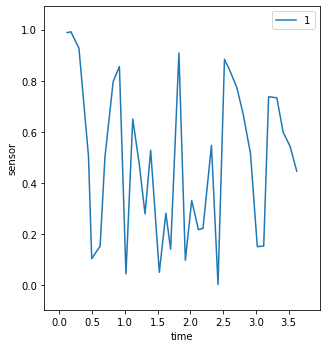

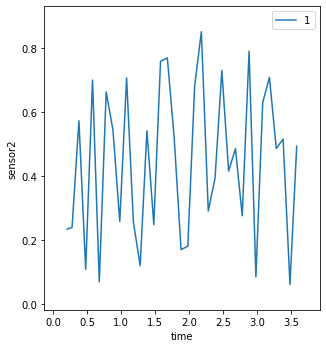

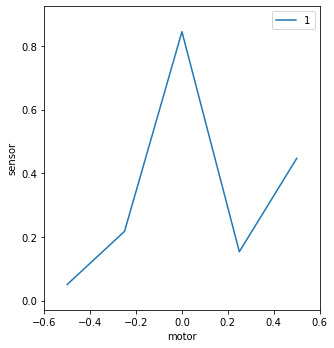

In [3]:
RE(bp.scan([sensor], motor, -0.5, 0.5, 5))
print(f"{h5_file.exists()=}  {h5_file=}")

In [4]:
from apstools.utils import unix

for line in unix(f"punx tree {nxwriter.file_name}"):
    print(line.decode().strip())

!!! WARNING: this program is not ready for distribution.

/tmp/nxwriter.h5 : NeXus data file
  @HDF5_Version = "1.12.1"
  @NeXus_version = "v2020.1"
  @creator = "NXWriter"
  @default = "entry"
  @file_name = "/tmp/nxwriter.h5"
  @file_time = "2022-08-12T13:37:29.597321"
  @h5py_version = "3.7.0"
  entry:NXentry
    @NX_class = "NXentry"
    @default = "data"
    @target = "/entry"
    duration:NX_FLOAT64[] = 
      @units = "s"
    end_time:NX_CHAR = b'2022-08-12T13:37:29.409840'
    entry_identifier --> /entry/instrument/bluesky/metadata/run_start_uid
    plan_name --> /entry/instrument/bluesky/metadata/plan_name
    program_name:NX_CHAR = b'bluesky'
    start_time:NX_CHAR = b'2022-08-12T13:37:25.745435'
    title:NX_CHAR = b'scan-S0001-8d28b3f'
    data:NXdata
      @NX_class = "NXdata"
      @axes = ["motor"]
      @signal = "sensor"
      @target = "/entry/data"
      EPOCH --> /entry/instrument/bluesky/streams/primary/sensor/time
      motor --> /entry/instrument/bluesky/streams/

## Export

Export the data from the databroker to an HDF5 file.

In [5]:
from apstools.callbacks import NXWriter
from apstools.utils import replay
import databroker

# This example uses 'cat' as defined above.  You use this next line:
# cat = databroker.databroker["YOUR_CATALOG_NAME"]

h5_file = pathlib.Path("/tmp/db_export.h5")

scan_id = 1  # TODO: you choose
nxwriter = NXWriter()
nxwriter.file_name = str(h5_file)
nxwriter.warn_on_missing_content = False
replay(cat.v1[scan_id], nxwriter.receiver)
print(f"{h5_file.exists()=}  {h5_file=}")

h5_file.exists()=True  h5_file=PosixPath('/tmp/db_export.h5')
